In [2]:
!pip install numpy matplotlib graphviz

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

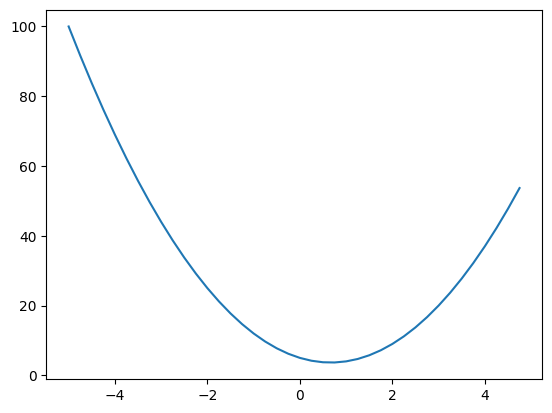

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

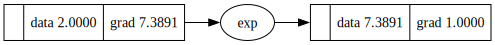

In [9]:
a = Value(2)
b = Value(3)
b = a.exp()
b.backward()
b.grad
draw_dot(b)

In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Install Graphviz

`brew install graphviz`

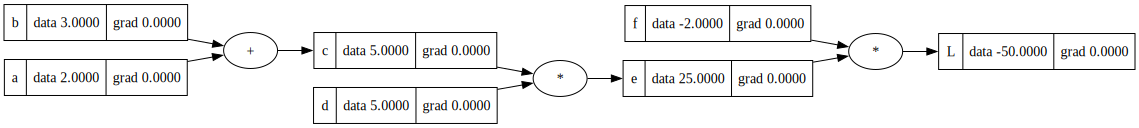

In [10]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a+b; c.label='c'
d = Value(5.0, label='d')
e = c*d; e.label='e'
f = Value(-2.0, label='f')
L = f*e; L.label='L'

draw_dot(L)

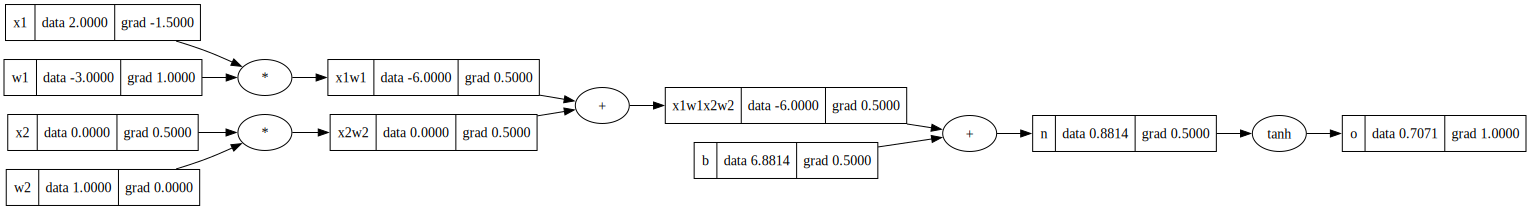

In [11]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#Linear functions
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label='x2w2'

#Final Product
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'

#output
n = x1w1x2w2 + b; n.label='n'

#Activation Function
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

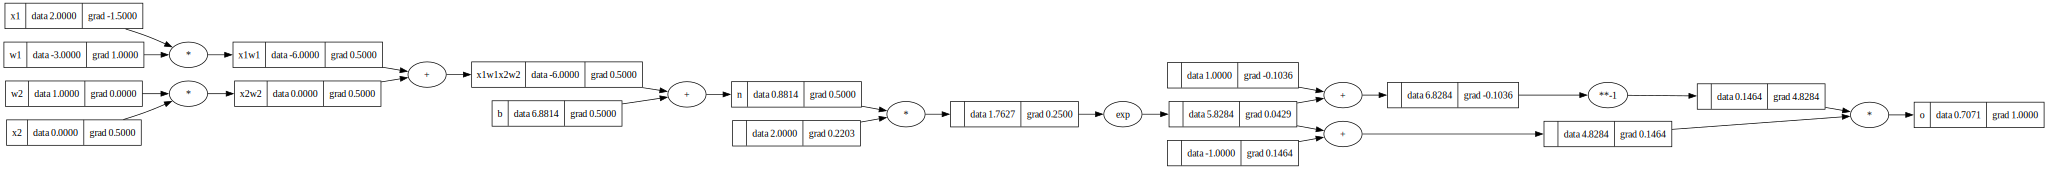

In [12]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#Linear functions
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label='x2w2'

#Final Product
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'

#output
n = x1w1x2w2 + b; n.label='n'

# ---
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ---

o.label = 'o'

o.backward()

draw_dot(o)

In [13]:
#Topological Sort

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2),
 Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=-1),
 Value(data=4.828427124746192),
 Value(data=0.7071067811865477)]

In [14]:
o.grad = 1.0

for node in reversed(topo):
    node._backward()

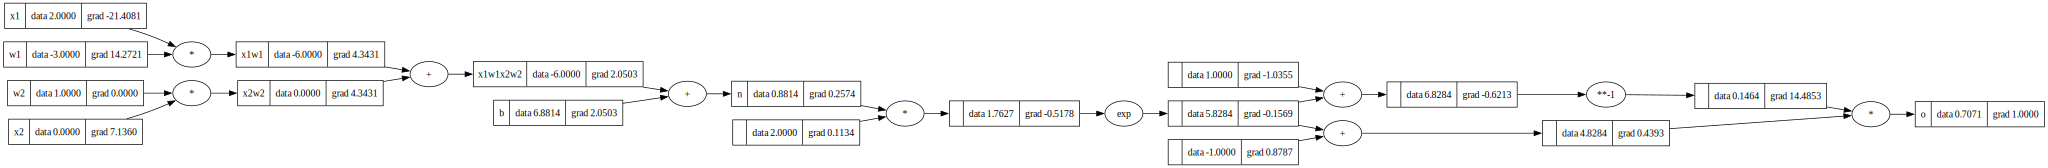

In [15]:
o.backward()

draw_dot(o)

In [16]:
import random

In [17]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

In [18]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [19]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
            for layer in self.layers:
                x = layer(x)
            return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [119]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)


[Value(data=-0.9911950763872021),
 Value(data=-0.9888412410515628),
 Value(data=0.9869327082860789)]

In [120]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8456877415075782)

In [121]:
len(n.parameters())

41

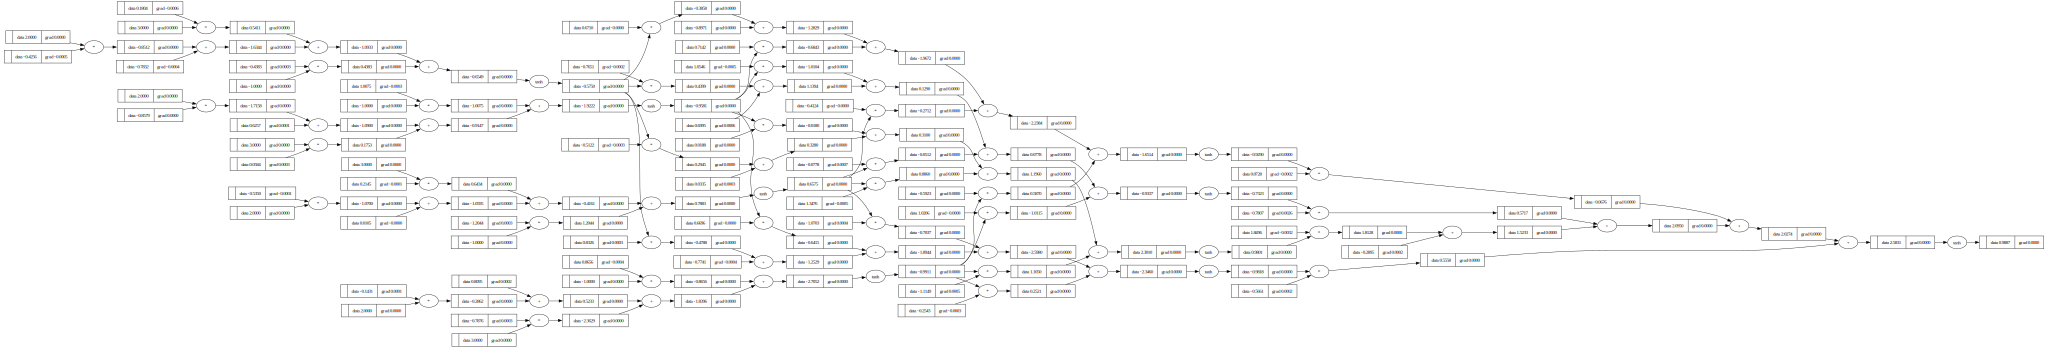

In [202]:
draw_dot(n(x))

In [123]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [196]:
for k in range(20):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))


    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
    # update
    for p in n.parameters():
        p.data += -0. * p.grad
  
    print(k, loss.data)

0 0.0008348473099572279
1 0.0008348473099572279
2 0.0008348473099572279
3 0.0008348473099572279
4 0.0008348473099572279
5 0.0008348473099572279
6 0.0008348473099572279
7 0.0008348473099572279
8 0.0008348473099572279
9 0.0008348473099572279
10 0.0008348473099572279
11 0.0008348473099572279
12 0.0008348473099572279
13 0.0008348473099572279
14 0.0008348473099572279
15 0.0008348473099572279
16 0.0008348473099572279
17 0.0008348473099572279
18 0.0008348473099572279
19 0.0008348473099572279


In [198]:

ypred = [n(x) for x in xs]
ypred

[Value(data=0.9886530271927652),
 Value(data=-0.981172366875293),
 Value(data=-0.9902837176210297),
 Value(data=0.9839623067206457)]

In [199]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0008348473099572279)

In [29]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [30]:
loss.backward()

In [200]:
n.layers[0].neurons[0].w[0].grad

-0.00046578418684826593

In [201]:
n.layers[0].neurons[0].w[0].data

-0.42559271721464503

In [33]:
n.layers[0].neurons[0].w[0].data

0.9659631145475088

In [34]:
n.parameters()

[Value(data=0.9659631145475088),
 Value(data=-0.38638271108469613),
 Value(data=0.7687245544317355),
 Value(data=0.9080958079808518),
 Value(data=-1.2436786746031547),
 Value(data=-1.0867006104882113),
 Value(data=-0.30737045467723617),
 Value(data=-1.4948085917938836),
 Value(data=2.107532542044196),
 Value(data=-0.48341242350314634),
 Value(data=1.3184720050984318),
 Value(data=1.066756833324361),
 Value(data=0.9443694062807271),
 Value(data=-0.10807034185521847),
 Value(data=1.9534524906624255),
 Value(data=0.3341641915409976),
 Value(data=0.8426215916874998),
 Value(data=-0.387651233079927),
 Value(data=-0.5130572962757185),
 Value(data=-2.0167966955403407),
 Value(data=0.2831744092611814),
 Value(data=-0.6049866448798122),
 Value(data=0.8686395205305601),
 Value(data=-0.1391070519594222),
 Value(data=-1.2798680757498193),
 Value(data=-1.344846870243676),
 Value(data=0.31412616444901825),
 Value(data=-0.3051976151573018),
 Value(data=-0.44535317709851224),
 Value(data=-0.1408286335